In [1]:
from datetime import datetime
import gcsfs

# setting up file system to be ble to read from buckets

fs = gcsfs.GCSFileSystem(project='sm4h-rxspace')

now = datetime.now()
dt = now.strftime('%Y-%m-%d %H:%M')
print(f'start time:\n{dt}')

# pip instlal requirements
!pip install pandas==0.25.0;
!pip install tqdm==4.33.0;

!pip install snorkel;
!pip install spacy;
!python -m spacy download en_core_web_md;
!pip install spacy-lookup;
!pip install lemminflect;
!pip install pandas-profiling;

start time:
2020-03-25 04:02
  Using cached tqdm-4.33.0-py2.py3-none-any.whl (50 kB)
ERROR: snorkel 0.9.3 has requirement torch<1.2.0,>=1.1.0, but you'll have torch 1.4.0 which is incompatible.
ERROR: en-core-web-md 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.9 which is incompatible.
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.43.0
    Uninstalling tqdm-4.43.0:
      Successfully uninstalled tqdm-4.43.0
  Using cached torch-1.1.0-cp37-cp37m-manylinux1_x86_64.whl (676.9 MB)
ERROR: allennlp 0.9.0 has requirement torch>=1.2.0, but you'll have torch 1.1.0 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 95.4 MB 97 kB/s eta 0:00:0101
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-py3-none-any.whl size=97126236 sha256=c14d1218b6108f9f243d8a8501fe754a9e7a430dc4ef064fc65778

In [2]:
# importing functions and etc
import spacy
from spacy.tokens import Doc, Span, Token
from spacy_lookup import Entity
from lemminflect import getAllInflectionsOOV
from spacy.matcher import Matcher
import en_core_web_md
import re
from snorkel.labeling import labeling_function, LabelModel, PandasLFApplier, LFAnalysis
from snorkel.preprocess import preprocessor
import io
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn


In [3]:
train_path = "gs://sm4h-rxspace/task4/train.csv"
dev_path = "gs://sm4h-rxspace/task4/validation.csv"
print(f'train path : {train_path}\ndev path : {dev_path}')

train path : gs://sm4h-rxspace/task4/train.csv
dev path : gs://sm4h-rxspace/task4/validation.csv


In [4]:
def get_distribution(df, col='class'):
    """gives distribution of a column """
    df_out = df[col].value_counts()
    n_train = df.shape[0]
    print(f"loaded {n_train} samples\n")

    df_out = pd.DataFrame(df_out)
    df_out.columns = ['class counts']
    df_out['class %'] = round(100 * df_out['class counts'] / n_train, 2)
    return df_out

df_raw = pd.read_csv(train_path)
df_raw['class'] = df_raw['class'].map(str.strip) # some labels have a trailing space
df_train = df_raw[['unprocessed_text']].rename(columns={'unprocessed_text':'text'})
df_labels = df_raw[['class']]

print(f'loading train from {train_path}..')

print(get_distribution(df_raw))

loading train from gs://sm4h-rxspace/task4/train.csv..
loaded 10537 samples

   class counts  class %
m  5488          52.08  
c  2940          27.90  
a  1685          15.99  
u  424           4.02   


In [5]:
df_val_raw = pd.read_csv(dev_path)
df_val_raw['class'] = df_val_raw['class'].map(str.strip)

df_val = df_val_raw[['unprocessed_text']].rename(columns={'unprocessed_text':'text'})
df_val_labels = df_val_raw[['class']]
print(f'loading dev from {dev_path}..')
print(get_distribution(df_val_raw))

loading dev from gs://sm4h-rxspace/task4/validation.csv..
loaded 2635 samples

   class counts  class %
m  1353          51.35  
c  730           27.70  
a  448           17.00  
u  104           3.95   


In [6]:
# loading bseline spacy model
nlp = en_core_web_md.load()

ABSTAIN = -1
ABUSE = 0
MENTION = 1
CONSUMPTION = 2
UNRELATED = 3

In [7]:
# TODO : add Whitley and Mark's drug list into the drugs dictionary
# drugname, is_slang, is_commonly_abused
drugs = {
    'alprazolam' : {
        'is_commonly_abused' : True,
        'slang_terms' : [
            'xanny', 'xannies'],
        'normal_terms' : [
            'xanax', 'xan', 'xanex', 'niravam'],
    },
    'codeine' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'codeine', 'codiene', 'cocet'],
    },
    'adderall' : {
        'is_commonly_abused' : True,
        'slang_terms' : [
            'addy', 'addies', 'addys'],
        'normal_terms' : [
            'adderall', 'aderall', 'adarall', 'addarall', 'adoral'],
    },
    'valium' : {
        'is_commonly_abused' : False,
        'slang_terms' : [],
        'normal_terms' : [
            'valium', 'vallium'],
    },
    'vyvanse' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'vyvanse'],
    },
    'fentanyl' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'fentanyl', 'fentynyl', 'fentenyl', 'fentanil', 'abstral', 
            'actiq', 'fentora', 'onsolis', 'sublimaze', 'duragesic'],
    },
    'oxycodone' : {
        'is_commonly_abused' : True,
        'slang_terms' : ['oxy'],
        'normal_terms' : [
            'oxycodone', 'oxaydo', 'xtampza', 'oxycontin', 'oxycotin', 'oxycodin'],
    },
    'hydrocodone' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'hydrocodone', 'hysingla', 'zohydro', 'vicodin', 'hycet',
            'lorcet', 'lortab', 'norco', 'verdrocet', 'xodol'],
    },
    'methadone' : {
        'is_commonly_abused' : False,
        'slang_terms' : [],
        'normal_terms' : [
            'methadone', 'dolophine', 'methadose'],
    },
    'morphine' : {'is_commonly_abused' : True,
                  'slang_terms' : [],
                  'normal_terms' : ['morphine', 'avinza', 'oramorph', 'roxanol', 'rms'],
                },
    'diazepam' : {'is_commonly_abused' : True,
                  'slang_terms' : [],
                  'normal_terms' : ['diazepam', 'valium'],
            },
    'tramadol' : {'is_commonly_abused' : False,
                  'slang_terms' : [],
                  'normal_terms' : ['tramadol', 'ultram'],
            },
    'quetiapine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['quetiapine', 'seroquel'],
            },
    'lorazepam' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['lorazepam', 'ativan'],
            },
    'clonazepam' : {'is_commonly_abused' : True,
                    'slang_terms' : [],
                    'normal_terms' : ['clonazepam', 'klonopin'],
            },
    'percocet' : {'is_commonly_abused' : True,
                  'slang_terms' : ['percs', 'perc'],
                  'normal_terms' : ['percocet', 'percacet', 'percicet'],
            },
    'aripiprazole' : {'is_commonly_abused' : False,
                      'slang_terms' : [],
                      'normal_terms' : ['aripiprazole', 'abilify'],
            },
    'buprenorphine' : {'is_commonly_abused' : False,
                       'slang_terms' : [],
                       'normal_terms' : ['buprenorphine', 'suboxone', 'naloxone', 'bunavail', 'zubsolv'],
            },
    'olanzapine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['olanzapine', 'zyprexa', 'zydis'],
            },
    'methylphenidate' : {'is_commonly_abused' : True,
                         'slang_terms' : [],
                         'normal_terms' : ['methylphenidate', 'aptensio', 'concerta', 'cotempla', 'metadate',
                                           'methylin',  'quillichew', 'quillivant', 'ritalin'],
            },
    'risperidone' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['risperidone ', 'risperdal'],
            },
    'caffeine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['caffeine', 'caffiene', 'coffee'],
            },
    'amphetamine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['amphetamine', 'adzenys', 'dyanavel'],
            },
    'hydromorphone' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['hydromorphone', 'dilaudid', 'exalgo', 'hydrostat'],
            },
}


verbs_slang = {'snort', 'crush', 'inject', 'pop', 'rail', 'sniff', 'trip', 'chug'
               'spill', 'binge', 'sling', 'slang', 'snortin'}



# generate dict that maps terms to keys and values includ parent term, is_slang, is_commonly_abused
drug_term_LUT = {}

for parent_term, subdict in drugs.items():
    for slang_term in subdict['slang_terms']:
        drug_term_LUT[slang_term] = {
        'parent_term' : parent_term,
        'is_slang' : True,
        'is_commonly_abused' : subdict['is_commonly_abused']
    }
        
    for normal_term in subdict['normal_terms']:
        drug_term_LUT[normal_term] = {
        'parent_term' : parent_term,
        'is_slang' : False,
        'is_commonly_abused' : subdict['is_commonly_abused']
    }

# creating pipes
drug_entity_pipe = Entity(keywords_list=list(drug_term_LUT.keys()), label='DRUG')
nlp.add_pipe(drug_entity_pipe, before='ner')

has_drug_term = lambda doc : any([True for ent in doc.ents if ent.label_ == 'DRUG'])
has_slang_drug_term = lambda doc : any([ent._.get('is_slang') for ent in doc.ents if ent.label_ == 'DRUG'])
has_commonly_abused_drug_term = lambda doc : any([ent._.get('is_commonly_abused') for ent in doc.ents if ent.label_ == 'DRUG'])


@preprocessor(memoize=True)
def nlpify(x):
    # preprocessor gets the series obj, so extract string
    doc = nlp(x['text'])
    Span.set_extension('is_commonly_abused', default=False, force=True)
    Span.set_extension('is_slang', default=False, force=True)
    for ent in doc.ents:
        if ent.label_ == 'DRUG':
            ent._.set('is_commonly_abused', drug_term_LUT[ent.text.lower()]['is_commonly_abused'])
            ent._.set('is_slang', drug_term_LUT[ent.text.lower()]['is_slang'])
            # for token in ent:
            #   token._.set('is_commonly_abused', drug_term_LUT[ent.text]['is_commonly_abused'])
            #   token._.set('is_slang', drug_term_LUT[ent.text]['is_slang'])
    Doc.set_extension('has_drug_term', getter=has_drug_term, force=True)
    Doc.set_extension('has_commonly_abused_drug_term', getter=has_commonly_abused_drug_term, force=True)
    Doc.set_extension('has_slang_drug_term', getter=has_slang_drug_term, force=True)
    return doc


In [8]:
# labeling fxns
@labeling_function(pre=[nlpify])
def drug_with_slang_usage(doc):
    '''check if drug name in text and mention of abusive use'''
    if doc._.has_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG':
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB' and head.lemma_ in verbs_slang:
                    return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def no_drugnames_found(doc):
    '''Check if no drugnames were found'''
    if not doc._.has_drug_term:
        return UNRELATED
    return ABSTAIN


@labeling_function(pre=[nlpify])
def slang_drug_with_usage(doc):
    '''check if a commonly abused drugname and there's a verb associated with it'''
    if doc._.has_slang_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG' and ent._.is_slang:
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB':
                    return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def normal_drug_with_usage(doc):
    '''check if a normal drugname and there's a non-slang verb associated with it'''
    if doc._.has_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG' and not ent._.is_slang:
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB' and head.lemma_ not in verbs_slang:
                    return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def slang_side_effects(doc):
    '''Drug mentioned and slang mention of a side effect'''
    effect_regexes = [
        'fuck(ed)? (me )?up',
        'fuck(ed)? with'
        'lit(ty)?',
        'high',
        'od', 'oveerdose(d)?',
        'addict(ed|ing)?',
        'hooked',
        'habit',
        'mellow',
        'doped',
        'hallucinat(e)?(d|ing)?',
        'trip(ping)?',
        'rollin(g)?',
        'buzz(ed)?'
        ]
    if doc._.has_drug_term and re.search('|'.join(effect_regexes), doc.text.lower()):
        return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drug_with_no_usage(doc):
    '''Drug mentioned but not in the context of being used'''
    if doc._.has_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG':
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB':
                    return ABSTAIN
    return MENTION


@labeling_function(pre=[nlpify])
def clinical_terms(doc):
    '''Drug mentioned but with cclinical terms around it'''
    medical_terms = {
        'doctor', 'nurse'  # TODO : add more medicl terms that indicate typical usage
        }
    medical_regex = r'(doctor|nurse|(re(- )?)?admi(t|ssion)(s)?|hospital)'
    if doc._.has_drug_term and medical_terms.intersection(set([t for t in doc])):
        return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def abusive_activities(doc):
    ''' drug usage mentioned for the purposes of unintended use '''
    activities = {
        'adderall': ['clean', 'study'],
        'vyvanse': ['study']
        }
    if doc._.has_drug_term:
        for ent in [ent for ent in doc.ents if ent.label_ == 'DRUG']:
            drug = drug_term_LUT.get(ent.text.lower())
            if drug:
                drug_activities = activities.get(drug['parent_term'])
                if drug_activities:
                    for token in doc:
                        if token.lemma_ in drug_activities:
                            return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def study_aid(doc):
    ''' drugs being useed speccifically as study aid '''
    if doc._.has_drug_term:
        study_aid_drugs = {'adderall', 'vyvanse'}
        drugs = set([drug_term_LUT.get(ent.label_.lower()) for ent in doc.ents if ent.label_ == 'DRUG'])
        if drugs.intersection(study_aid_drugs):
            study_regex = r'(wak(e|ing)|study(ing)?|homework|school(s)?|libar(y|ies)|education|class(es)?|semester(' \
                          r's)?|exam(s)?|paper(s)?|campus|essay(s)?|college|uni(versity)?)'
            if re.search(study_regex, doc.text.lower()):
                return abuse
    return ABSTAIN


@labeling_function(pre=[nlpify])
def soliciting_drug(doc):
    '''Check if there is a regex pattern indicating the persom asking for drug'''
    if doc._.has_drug_term:
        regex = "(any ?one|someone|any ?body|who|y'all|I|gonna).*(" \
                "steal|stole|get|got|has|had|have|holding|find|found|need(ed)?|want|share).*"
        if re.search(regex, doc.text.lower()):
            return ABUSE
        other_soliciting_terms = {'hmu', }
        if other_soliciting_terms.intersection(set([token.text.lower() for token in doc])):
            return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def suspicious_emojis(doc):
    '''drug mentioned and has emojis commonly used when mentioning abuse'''
    suspicious_emojis = {'💊', '🍁', '🍀', '🌴', '🌳', '🌲', '💨'
                                                             '❄', '⛄', '🔑', '🌨', '🍚', '🤧', '🎱',
                         '💉', '🎯', '🐉', '🍄', }  # TODO add more suspicious emojis
    if doc._.has_drug_term and suspicious_emojis.intersection(set([t for t in doc])):
        return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def expected_usage(doc):
    '''check for each drug mentioned whether theres a mention of a term commonly associated with expected usage'''
    usage = {
        'seroquel': {'sleep', 'insomnia'},  # TODO : add more common drug usage matches
        'xanax': {'anxiety'},
        }
    if doc._.has_drug_term:
        token_set = set([t for t in doc])
        for ent in doc.ents:
            if ent.label_ == 'DRUG':
                if usage.get(ent.text.lower(), set()).intersection(token_set):
                    return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def lyrica_as_nondrug(doc):
    if 'lyrica' in doc.text.lower() and re.search('(anderson|lhhh|song|ginny|breisha|lgbt(q)?)', doc.text.lower()):
        return UNRELATED

    with nlp.disable_pipes('entity'):
        w_doc = nlp(doc.text)
        lyrica_person = False
        for ent in w_doc.ents:
            if 'lyrica' in ent.text.lower() and ent.label_ == 'PERSON':
                lyrica_person = True
        if lyrica_person:
            found_other_drug_term = False
            for ent in doc.ents:
                if 'lyrica' not in ent.text.lower() and ent.label_ == 'DRUG':
                    found_other_drug_term = True
            if not found_other_drug_term:
                return UNRELATED

    textlist = doc.text.replace('_U', '').lower().split()
    if 'lyrica' in textlist:
        if len(textlist) < 5:
            return UNRELATED
        else:
            for ent in doc.ents:
                if 'lyrica' in ent.text.lower() and ent.label_ != 'DRUG':
                    return UNRELATED
    return ABSTAIN


@labeling_function(pre=[nlpify])
def buy_or_sell(doc):
    if doc._.has_drug_term:
        lemmas = set([token.lemma_ for token in doc])
        if 'buy' or 'sell' in lemmas:
            return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def short_tweet(doc):
    if doc._.has_drug_term and len(doc.text.split()) <= 5:
        return MENTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def chill_pill(doc):
    '''someone tells another person to take some drug to calm down'''
    if doc._.has_drug_term:
        found_drugs = set([ent.text.lower() for ent in doc.ents if ent.label_ == 'DRUG'])
        if found_drugs:
            chill_regex = "take (a|some)[a-z _-]{0,10}(" + '|'.join(found_drugs) + ')'
            if re.search(chill_regex, doc.text.lower()):
                return MENTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drugs_for_sleep(doc):
    ''' mentions of drugs used to help sleep '''
    if doc._.has_drug_term and re.search(r"(sleep(ing)?|(good[ ]?)?night)", doc.text.lower()):
        return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drug_feels_like(doc):
    '''someone mentioning one drug is like something else : ampetemine is like adderall'''
    if doc._.has_drug_term and re.search(r"(is|it(\')?s)[ ,a-z0-9]{,8}(like|similar)", doc.text.lower()):
        return MENTION
    return ABSTAIN



In [9]:
## TODO RULES

# anything + alchcohol
# anyhtin + energy drink

# check for drugs that are mentioned in the hashtag, e.g. #aderrall (not captured by nlp?)

@labeling_function(pre=[nlpify])
def mixing_drugs(doc):
    '''mention of mixing drugs often used in abuse'''
    # map to all alias terms
    abuse_pairs = [
        ('ambien', 'percocet'),
        ('adderall', 'alcohol'),
        ('adderall', 'coffee'),
        ]
    if doc._.has_drug_term:
        pdrugs = [drug_term_LUT.get(ent.text.lower(), {}).get('parent_term') for ent in doc.ents if
                  ent.label_ == 'DRUG']
        drugset = set([drug for drug in pdrugs if drug])
        if len(drugset) >= 2:
            drug_pairs = itertools.combinations(drugset, 2)
            for pair in drug_pairs:
                if pair in abuse_pairs:
                    return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def person_on_rx(doc):
    ''' mention where person indicates the drug is and rx'''
    if doc._.has_drug_term and not doc._.has_slang_drug_term:
        if re.search('(got|have)[ ]+(me|him|her|my) (on|taking|using)', doc.text.lower()):
            return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drug_had_me(doc):
    ''' adderall had me ..., indicating side effect of normal use'''
    if doc._.has_drug_term:
        for ent in [ent for ent in doc.ents if ent.label_ == 'DRUG']:
            if drug_term_LUT.get(ent.text, {}).get('parent_term') in {'adderall', 'vyvanse'}:
                idx = doc.text.index(ent.text)
                if re.search('^[ ]*(have|has|had|got) (me|her|him|them)', doc.text.lower()[idx + len(ent.text):]):
                    return CONSUMPTION
    return ABSTAIN

In [10]:
lfs = [drug_with_slang_usage,
       no_drugnames_found,
       slang_drug_with_usage,
       normal_drug_with_usage,
       slang_side_effects,
       drug_with_no_usage,
       clinical_terms,
       abusive_activities,
       study_aid,
       soliciting_drug,
       suspicious_emojis,
       expected_usage,
       lyrica_as_nondrug,
       buy_or_sell,
       short_tweet,
       chill_pill,
       drugs_for_sleep,
       drug_feels_like,
       mixing_drugs,
       person_on_rx,
       drug_had_me
       ]

# appling with pandas LF applier
applier = PandasLFApplier(lfs)
# applying to datasets

L_train = applier.apply(df_train, progress_bar=True)

L_val = applier.apply(df_val, progress_bar=True)

class2label = {'a': 0, 'm': 1, 'c': 2, 'u': 3}
Y = df_labels['class'].map(lambda x: class2label[x]).to_numpy()

Y_val = df_val_labels['class'].map(lambda x: class2label[x]).to_numpy()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
100%|██████████| 10537/10537 [14:13<00:00, 12.35it/s]
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
100%|██████████| 2635/2635 [03:34<00:00, 12.29it/s]


In [11]:

## summary anlysis 
summary_analysis = LFAnalysis(L_train, lfs).lf_summary(Y)
summary_analysis

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
drug_with_slang_usage,0,[0],0.016893,0.016893,0.000949,76,102,0.426966
no_drugnames_found,1,[3],0.074689,0.074689,0.074689,329,458,0.418043
slang_drug_with_usage,2,[0],0.002278,0.002278,0.000475,4,20,0.166667
normal_drug_with_usage,3,[2],0.454589,0.454589,0.454589,1581,3209,0.330063
slang_side_effects,4,[0],0.225871,0.225871,0.222169,440,1940,0.184874
drug_with_no_usage,5,[1],0.527285,0.527285,0.527285,3003,2553,0.540497
clinical_terms,6,[],0.000000,0.000000,0.000000,0,0,0.000000
abusive_activities,7,[0],0.007497,0.007497,0.007308,45,34,0.569620
study_aid,8,[],0.000000,0.000000,0.000000,0,0,0.000000
soliciting_drug,9,[0],0.029515,0.029515,0.029230,94,217,0.302251


In [12]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)  # , class_balance=[.15, .5, .3, .05]);
df_train["label"] = label_model.predict(L=L_train, tie_break_policy="abstain")
df_val["label"] = label_model.predict(L=L_val, tie_break_policy="abstain")
# looking at weights
weights = summary_analysis[['j']]
weights['w'] = [round(w, 3) for w in label_model.get_weights()]
weights

/opt/conda/lib/python3.7/site-packages/snorkel/labeling/model/label_model.py:378: RuntimeWarning: divide by zero encountered in true_divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,j,w
drug_with_slang_usage,0,0.591
no_drugnames_found,1,1.000
slang_drug_with_usage,2,0.828
normal_drug_with_usage,3,0.550
slang_side_effects,4,0.484
drug_with_no_usage,5,0.474
clinical_terms,6,1.000
abusive_activities,7,0.154
study_aid,8,1.000
soliciting_drug,9,0.435


In [13]:

# organizing data
df_train['groundtruth'] = df_labels['class']
df_train['predicted_class'] = df_train['label'].map({-1: None, 0: 'a', 1: 'm', 2: 'c', 3: 'u'})
df_train['correct?'] = df_train['groundtruth'] == df_train['predicted_class']

df_val['groundtruth'] = df_val_labels['class']
df_val['predicted_class'] = df_val['label'].map({-1: None, 0: 'a', 1: 'm', 2: 'c', 3: 'u'})
df_val['correct?'] = df_val['groundtruth'] == df_val['predicted_class']


In [14]:
acc_train = label_model.score(L=L_train, Y=Y, tie_break_policy="abstain",
                              metrics=["f1_macro", "f1_micro", "accuracy"])
print('\nTraining Data Performance')
print(f"{'Model F1 Macro':<25} {acc_train['f1_macro'] * 100:.1f}%")
print(f"{'Model F1 Micro:':<25} {acc_train['f1_micro'] * 100:.1f}%")

acc_val = label_model.score(L=L_val, Y=Y_val, tie_break_policy="abstain",
                            metrics=["f1_macro", "f1_micro", "accuracy"])
print('\n\nValidation Data Performance')
print(f"{'Model F1 Macro':<25} {acc_val['f1_macro'] * 100:.1f}%")
print(f"{'Model F1 Micro:':<25} {acc_val['f1_micro'] * 100:.1f}%")


Training Data Performance
Model F1 Macro            40.3%
Model F1 Micro:           38.8%


Validation Data Performance
Model F1 Macro            40.6%
Model F1 Micro:           39.0%


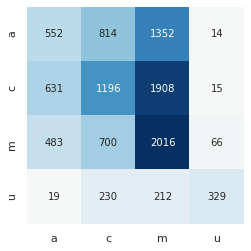

In [15]:
labels_ = ['a', 'c', 'm', 'u']
cmat = confusion_matrix(df_train['groundtruth'][~pd.isnull(df_train['predicted_class'])],
                        df_train['predicted_class'][~pd.isnull(df_train['predicted_class'])],
                        labels=labels_)
df_cmat = pd.DataFrame(cmat.T, labels_, labels_)
sn.set(font_scale=1)  # for label size
sn.heatmap(df_cmat, annot=True, annot_kws={"size": 10}, fmt='d', cbar=False,
           cmap='RdBu', center=0, square=True)  # font size

plt.show()

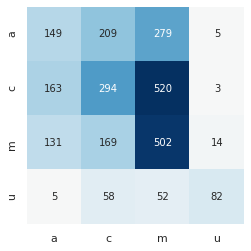

In [16]:
cmat = confusion_matrix(df_val['groundtruth'][~pd.isnull(df_val['predicted_class'])],
                        df_val['predicted_class'][~pd.isnull(df_val['predicted_class'])],
                        labels=labels_)
df_cmat = pd.DataFrame(cmat.T, labels_, labels_)
sn.set(font_scale=1)  # for label size
sn.heatmap(df_cmat, annot=True, annot_kws={"size": 10}, fmt='d', cbar=False,
           cmap='RdBu', center=0, square=True)  # font size

plt.show()

In [17]:
df_train.groupby('groundtruth')['text'].count()

df_train.groupby('predicted_class')['text'].count()

predicted_class
a    2732
c    3750
m    3265
u    790 
Name: text, dtype: int64

In [18]:
import sklearn.metrics as sklm

print(sklm.classification_report(y_true=df_val['groundtruth'][~pd.isnull(df_val['predicted_class'])],
                        y_pred = df_val['predicted_class'][~pd.isnull(df_val['predicted_class'])],
                        labels=labels_))

              precision    recall  f1-score   support

           a       0.23      0.33      0.27       448
           c       0.30      0.40      0.34       730
           m       0.62      0.37      0.46      1353
           u       0.42      0.79      0.54       104

    accuracy                           0.39      2635
   macro avg       0.39      0.47      0.41      2635
weighted avg       0.45      0.39      0.40      2635



In [19]:
drugs = {
    'acetaminophen',
    'hydrocodone',
    'codeine',
    'chlorpheniramine',
    'morphine',
    'buprenorphine',
    'hydromorphone',
    'butorphanol',
    'ipratropium',
    'fentanyl',
    'oxycodone',
    'methadone',
    'tramadol',
    'aspirin',
    'guaifenesin',
    'caffeine',
    'nalbuphine',
    'homatropine',
    'remifentanil',
    'sufentanil',
    'naloxone',
    'meperidine',
    'dihydrocodeine',
    'oxymorphone',
    'ibuprofen',
    'phenylephrine',
    'brompheniramine',
    'pseudoephedrine',
    'pentazocine',
    'butalbital',
    'carisoprodol',
    'promethazine',
    'levorphanol',
    'vicodin',
    'anexsia',
    'lorcet',
    'taxadone',
    'reprexain',
    'dolacet',
    'xylon',
    'cocet',
    'tussicaps',
    'kadian',
    'subutex',
    'dilaudid',
    'torbugesic',
    'atrovent',
    'xodol',
    'duragesic',
    'norco',
    'percocet',
    'endocet',
    'lynox',
    'oramorph',
    'dolophine',
    'dazidox',
    'physeptone',
    'ultram',
    'roxanol',
    'duocet',
    'oxynorm',
    'actiq',
    'lortab',
    'nubain',
    'ryzolt',
    'perloxx',
    'morphabond',
    'zydol',
    'sevredol',
    'roxicodone',
    'hydrotropine',
    'hydromide',
    'astramorph',
    'ultiva',
    'sufenta',
    'ionsys',
    'tramake',
    'oxycontin',
    'percodan',
    'tylenol',
    'suboxone',
    'zamadol',
    'trezix',
    'verdrocet',
    'oncet',
    'glydeine',
    'procet',
    'demerol',
    'roxicet',
    'stadol',
    'roxilox',
    'endodan',
    'maxidone',
    'zerlor',
    'synalgos-dc',
    'combunox',
    'panlor',
    'butorphic',
    'tuzistra',
    'methadose',
    'tylagesic',
    'zomorph',
    'opana',
    'depodur',
    'ibudone',
    'pethilorfan',
    'vanacet',
    'hyco-pap',
    'aceon',
    'hycodan',
    'hydrogesic',
    'primlev',
    'zydone',
    'co-gesic',
    'phenco-care',
    'tussionex',
    'sublimaze',
    'msir',
    'm-eslon',
    'hydropane',
    'magnacet',
    'onsolis',
    'vendone',
    'eth-oxydose',
    'hydromet',
    'm-oxy',
    'pyregesic',
    'oxecta',
    'm-phen',
    'vidone',
    'margesic-h',
    'codrix',
    'hy-phen',
    'tussigon',
    'zamicet',
    'ascomp',
    'rms',
    'oxyrapid',
    'duramorph',
    'hycomed',
    'endocodone',
    'guai-co',
    'conzip',
    'ugesic',
    'rybix',
    'stagesic',
    'zolvit',
    'brontex',
    'codafen',
    'oxydose',
    'vicoprofen',
    'ultracet',
    'panacet',
    'hycet',
    'zyfrel',
    'methex',
    'hydrostat',
    'duoneb',
    't-gesic',
    'cheratussin',
    'tramalgin',
    'percolone',
    'polygesic',
    'allay',
    'oxyfast',
    'buprenex',
    'dolagesic',
    'tylox',
    'oxaydo',
    'hydrocet',
    'talacen',
    'l-dromoran',
    'fentora',
    'alprazolam',
    'chlordiazepoxide',
    'clonazepam',
    'diazepam',
    'estazolam',
    'flurazepam',
    'lorazepam',
    'oxazepam',
    'temazepam',
    'triazolam',
    'clobazam',
    'clorazepate',
    'quazepam',
    'calprazolam',
    'niravam',
    'xanax',
    'chlordinium',
    'clindex',
    'h-tran',
    'librax',
    'libritabs',
    'librium',
    'limbitrol',
    'mitran',
    'poxi',
    'tropium',
    'ceberclon',
    'klonopin',
    'rivotril',
    'valpax',
    'alupram',
    'atensine',
    'd-val',
    'dialar',
    'diastat',
    'diazemuls',
    'dizac',
    'evacalm',
    'rimapam',
    'stesolid',
    'tensium',
    'valicot',
    'valium',
    'zetran',
    'prosom',
    'dalmane',
    'almazine',
    'ativan',
    'serax',
    'restoril',
    'halcion',
    'frisium',
    'onfi',
    'gen-xene',
    'tranxene',
    'doral',
    'asenapine',
    'clozapine',
    'risperidone',
    'aripiprazole',
    'brexpiprazole',
    'cariprazine',
    'iloperidone',
    'lurasidone',
    'olanzapine',
    'paliperidone',
    'pimavanserin',
    'quetiapine',
    'ziprasidone',
    'saphris',
    'clozaril',
    'fazaclo',
    'versacloz',
    'risperdal',
    'abilify',
    'aristada',
    'rexulti',
    'vraylar',
    'fanapt',
    'latuda',
    'symbyax',
    'zyprexa',
    'invega',
    'nuplazid',
    'seroquel',
    'geodon',
    'amphetamine',
    'dextroamphetamine',
    'doxapram',
    'lisdexamfetamine',
    'methamphetamine',
    'methylphenidate',
    'tropicamide',
    'armodafinil',
    'dexmethylphenidate',
    'modafinil',
    'p-hydroxyamphetamine',
    'adderall',
    'adderall-xr',
    'evekeo',
    'mydayis',
    'dexedrine',
    'dextrostat',
    'durophet',
    'liquadd',
    'procentra',
    'zenzedi',
    'dopram',
    'respiram',
    'vyvanse',
    'desoxyn',
    'aptensio',
    'concerta',
    'metadate',
    'methylin',
    'quillivant',
    'ritalin',
    'ritalin-sr',
    'paremyd',
    'nuvigil',
    'focalin',
    'aller-tec',
    'provigil',
    }

drug_rex = "(" + '|'.format(drugs) + ")"
df_train['text'] = df_train['text'].map(str)

df_drugs = df_train[df_train.text.map(lambda x: re.search(drug_rex, x.lower()) is not None)]
df_drugs.sample(7)

,text,label,groundtruth,predicted_class,correct?
2196,_U _U _U yeah & i have xanax &painkillers to help me lol my ankle is still f'ed..wore tennis shoes & brace,2,c,c,True
34,pop an adderall i'm sweatin woooo😎,0,c,a,False
1799,"Pretty pissed that I was on morphine and tramadol for weeks when I was sick and I never tripped, not once",0,c,a,False
3682,_U that's what i say every time i don't take my adderall,2,c,c,True
8049,_U xanax is garbage.,2,m,c,False
1658,the amount of seroquel i'm on could probably tranquilize a horse,1,c,m,False
4101,_U in between shots i take lyrica and bacfolan,3,c,u,False


In [20]:
for d in drugs:
    df_drugs[d] = df_train.text.map(lambda x: 1 if d in x.lower() else 0)
    
df_drugs.sample(3)

,text,label,groundtruth,predicted_class,correct?,methex,oxyfast,carisoprodol,remifentanil,torbugesic,...,valpax,temazepam,procentra,anexsia,stagesic,naloxone,duocet,vyvanse,methadone,hy-phen
1948,oxycodone is a wonderful pain medication lmao. #thanksdoc,0,c,a,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3091,They gave me hydrocodone for my foot lol,0,c,a,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4886,_U not just fake xanax popped in scripted series either...but also real xanax being popped... those housewives love their xanax,0,m,a,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_drug_mentions = df_drugs.drop(columns=['text', 'label', 'groundtruth', 'predicted_class', 'correct?'])

df_drug_mentions_sum = df_drug_mentions.sum().sort_values(ascending=False)

df_drug_mentions_sum[df_drug_mentions_sum > 5]

xanax            2124
adderall         1969
morphine         1322
valium           846 
tramadol         577 
methadone        415 
oxycodone        340 
oxycontin        325 
vyvanse          300 
hydrocodone      256 
seroquel         232 
ativan           229 
klonopin         216 
suboxone         195 
diazepam         191 
codeine          138 
abilify          100 
quetiapine       83  
lorazepam        70  
fentanyl         66  
clonazepam       63  
percocet         60  
cocet            60  
alprazolam       48  
olanzapine       45  
zyprexa          42  
buprenorphine    40  
vicodin          38  
ritalin          35  
rms              29  
risperidone      26  
caffeine         24  
risperdal        23  
ibuprofen        23  
amphetamine      22  
tylenol          21  
dilaudid         19  
norco            18  
aripiprazole     16  
onfi             10  
geodon           10  
dolophine        9   
promethazine     9   
aspirin          8   
acetaminophen    8   
temazepam 